In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

## Dataset loading

In [4]:
from utils.dataset_loader import load_datasets

(texts_train, labels_train), (texts_val, labels_val), (texts_test, labels_test) = load_datasets(folder_path='dataset', 
                                                                                                divide_by_sentence=True)

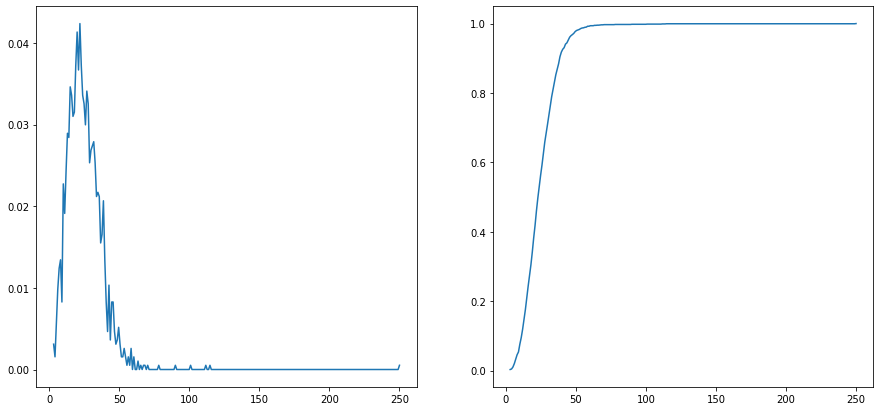

In [5]:
train_sentences_len = [len(phrase.split(' ')) for phrase in texts_train]

hist, bin_edges = np.histogram(train_sentences_len, bins=np.max(train_sentences_len) + 1, density=True) 
C = np.cumsum(hist)*(bin_edges[1] - bin_edges[0])

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(bin_edges[1:], hist)
plt.subplot(1, 2, 2)
plt.plot(bin_edges[1:], C)
plt.show()

In [6]:
percentile = 0.99

np.where(C > percentile)[0][0]

56

# Load GloVe

In [7]:
from utils.glove_loader import load_glove

embedding_dimension = 50

GLOVE_embeddings = load_glove(folder_path='glove_pretrained', embedding_dim=embedding_dimension)

# Preprocess Cardinal Numbers

In [8]:
import re

def substitute_numeric(texts):
    # The word is either an integer number or a flaoting point (with either . or ,) or two integers divided by "\/".
    pattern = '^[0-9]+((\\\\\/|\,|\.)[0-9]*)?$'
    substitution = '[num]'
    
    return [' '.join([re.sub(pattern, substitution, word) for word in sentence.split(' ')]) for sentence in texts]

texts_train = substitute_numeric(texts_train)
texts_val = substitute_numeric(texts_val)
texts_test = substitute_numeric(texts_test)

# OOV Terms Handling (Train set)

In [9]:
split_train_sentences = [sentence.lower().split(' ') for sentence in texts_train]
tokens = set([t for sentence in split_train_sentences for t in sentence])
n_tokens = len(tokens)
token2int = dict(zip(tokens, range(len(tokens))))
int2token = {v: k for k,v in token2int.items()}

In [22]:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10][:100]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [24]:
from utils.oov_handler import get_co_occurrence_matrix

print('Building co-occurence matrix...')
co_occurrence_matrix = get_co_occurrence_matrix(tokens, token2int, split_train_sentences, window_size=5)
print('Co-occurence matrix shape:', co_occurrence_matrix.shape)

Building co-occurence matrix...
Co-occurence matrix shape: (6981, 6981)


In [25]:
from utils.oov_handler import train_oov_terms
weights, losses = train_oov_terms(GLOVE_embeddings, co_occurrence_matrix, token2int, int2token)

AssertionError: Torch not compiled with CUDA enabled

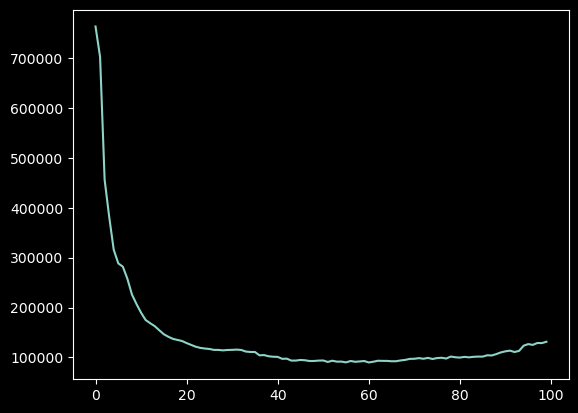

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
print(len(tokens))
print(weights.shape)

6981
torch.Size([6981, 50])


In [ ]:
embeddings_train = { t: weights[i].cpu().numpy() for i, t in enumerate(tokens) }
embeddings_train.update(GLOVE_embeddings)

print(len(embeddings_train.keys()))

400309
